# RNN Track Filter for tree search

In this notebook we will take the trained RNN hit predictor and apply it to track search on ACTS events.

In [19]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['OMP_NUM_THREADS'] = '4'
cuda = False

In [20]:
from __future__ import print_function

# Externals
import numpy as np
import pandas as pd
import torch
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Local imports
from data import process_files
from track_filter import select_hits, select_signal_hits, coord_scale
from track_filter import remove_duplicate_hits_2 as remove_duplicate_hits
import torchutils
torchutils.set_cuda(cuda)
from torchutils import np_to_torch, torch_to_np

%matplotlib notebook

In [21]:
data_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'
model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNGausFilter_012/model'
#model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNGausFilter_20171215_1130/model'
#model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter-2/model'

## Load a held-out test set

10 files were set aside for this test. Take from the back of the list.

In [22]:
%%time
n_files = 1
n_workers = 1

all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(data_dir, f) for f in hits_files[-n_files:]]

hits = process_files(hits_files, num_workers=n_workers)
print('Hits data shape:', hits.shape)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_99.csv
Hits data shape: (529333, 7)
CPU times: user 46.9 ms, sys: 64.6 ms, total: 111 ms
Wall time: 1min 10s


In [23]:
%%time

# Select hits
selected_hits = remove_duplicate_hits(select_hits(hits))
print('selected barrel hits:', selected_hits.shape)
signal_hits = select_signal_hits(selected_hits)
print('signal track hits:', signal_hits.shape)

event_groups = selected_hits.groupby('evtid')
sample_keys = signal_hits[['evtid', 'barcode']].drop_duplicates().values

print('Available sample keys:', sample_keys.shape[0])

selected barrel hits: (270060, 7)
signal track hits: (136910, 7)
Available sample keys: 13691
CPU times: user 55.9 s, sys: 114 ms, total: 56 s
Wall time: 56 s


In [24]:
cov_scale = coord_scale[:2, None] * coord_scale[None, :2]
feature_names=['phi', 'z', 'r']

# Load the pre-trained model
model = torch.load(model_file)
model.eval()
model

HitGausPredictor(
  (lstm): LSTM(3, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5)
)

In [25]:
def translate_phi(phi, phi0):
    dphi = phi - phi0
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def center_hits_phi(hits, phi0):
    hits.phi = translate_phi(hits.phi, phi0)
    
def make_inputs(x):
    """
    Takes a dataframe of hits and extracts out the model input features.    
    Scales the coordinates by standard factors and prepends a batch dimension.
    """
    return np_to_torch(
        (x[feature_names].values / coord_scale)
        .astype(np.float32))[None, :]

def parse_outputs(outputs):
    means = torch_to_np(outputs[0][:, -1]) * coord_scale[:2]
    covs = torch_to_np(outputs[1][:, -1]) * cov_scale
    return means, covs

## Apply model to select hits

In [26]:
n_det_layers = 10
seed_size = 3
n_features = len(feature_names)
n_samples = 10240

# Dataframe indices of selected hits
indices = np.zeros((n_samples, n_det_layers), dtype=np.int)
# Truth labels for selected hits
labels = np.zeros((n_samples, n_det_layers), dtype=np.float32)
# Model predictions, means and cov-matrix
pred_means = np.zeros((n_samples, n_det_layers - seed_size, 2))
pred_covs = np.zeros((n_samples, n_det_layers - seed_size, 2, 2))

In [27]:
%%time

# Loop over samples
for i, k in enumerate(sample_keys[:n_samples]):

    # Gather the data
    sample_hits = event_groups.get_group(k[0]).sort_values('layer')
    sample_labels = sample_hits.barcode == k[1]
    
    # Prepare the seed
    seed_hits = sample_hits[(sample_hits.layer < seed_size) &
                            (sample_hits.barcode == k[1])]
    indices[i, :seed_size] = seed_hits.index
    
    # Center hits in phi on the first layer seed hit
    phi0 = sample_hits.phi.loc[indices[i,0]]
    center_hits_phi(sample_hits, phi0)
    
    for layer in range(seed_size, n_det_layers):        
        # Calculate the prediction for next layer
        input_idx = indices[i, :layer]
        model_input = make_inputs(sample_hits.loc[input_idx])
        means, covs = parse_outputs(model(model_input))
        pred_means[i, layer-seed_size] = means
        pred_covs[i, layer-seed_size] = covs
        
        # Construct the gaussian distribution. We have to use the scaled coordinates
        # Or we get rounding errors because of the scale of phi and z.
        gaus = multivariate_normal(means[0] / coord_scale[:2], covs[0] / cov_scale)
        #gaus = multivariate_normal(means[0], covs[0], allow_singular=True)

        # Select all hits on the next layer
        layer_hits = sample_hits[sample_hits.layer == layer]

        # Calculate likelihood scores for each of the hits.
        # Remember: the gaus object consumes scaled coordinates.
        scores = gaus.pdf(layer_hits[['phi', 'z']] / coord_scale[:2])
        
        # Get the dataframe index of the highest scored hit
        hit_idx = layer_hits.index[scores.argmax()]

        # Save this hit
        indices[i, layer] = hit_idx

    # Save all the truth labels for this sample
    labels[i] = sample_labels.loc[indices[i]]

CPU times: user 6min 56s, sys: 5.03 s, total: 7min 1s
Wall time: 7min 1s


In [28]:
print('Fraction of correctly selected hits:', labels[:, seed_size:].mean())

Fraction of correctly selected hits: 0.999888


<IPython.core.display.Javascript object>


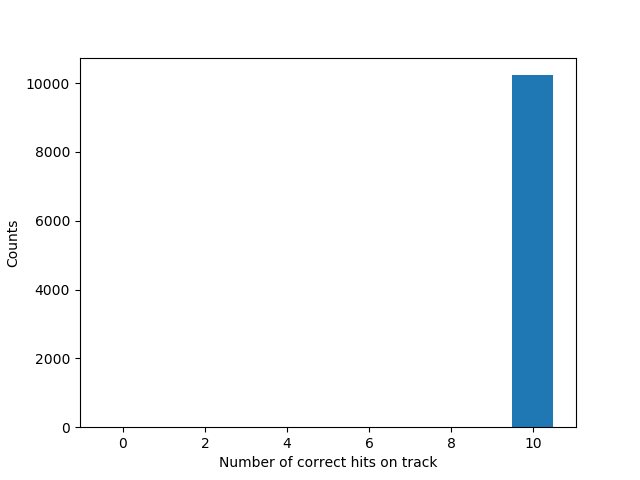

In [29]:
# Draw histogram of the number of correct hits in the predictions
correct_counts = labels.sum(axis=1)

plt.figure()
plt.hist(correct_counts, range=(-0.5, 10.5), bins=11)
plt.xlabel('Number of correct hits on track')
plt.ylabel('Counts');

## Visualize some samples

In [30]:
# Randomly drawn samples
n_draw = 5
draw_samples = np.random.randint(n_samples, size=n_draw)

<IPython.core.display.Javascript object>


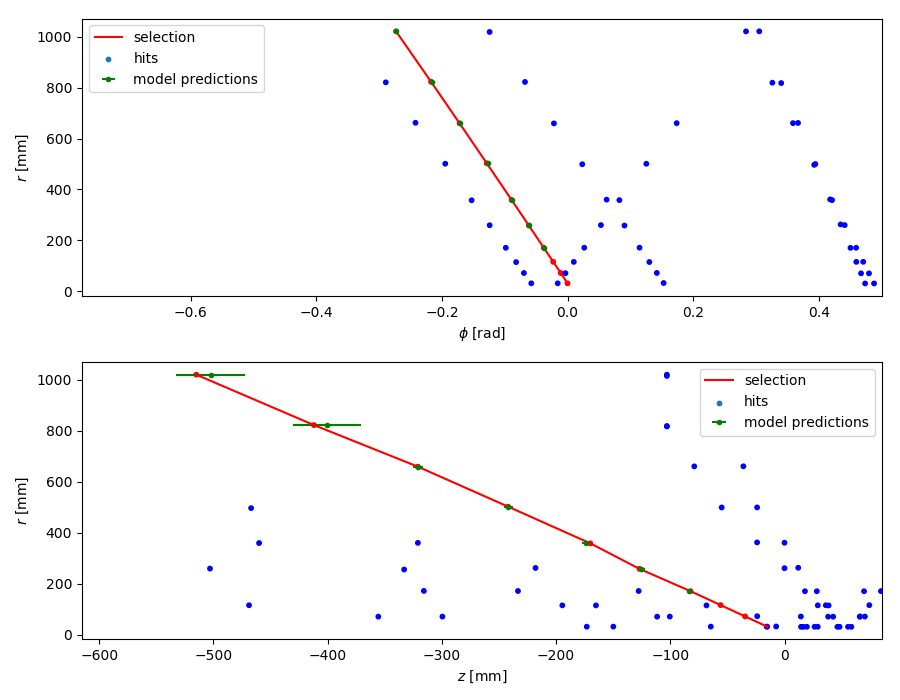

<IPython.core.display.Javascript object>


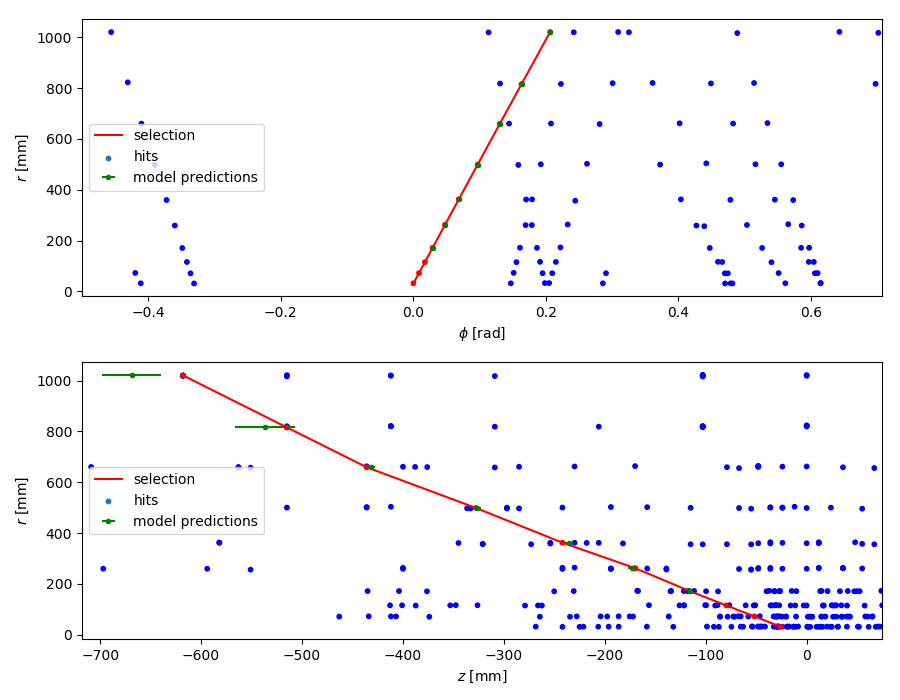

<IPython.core.display.Javascript object>


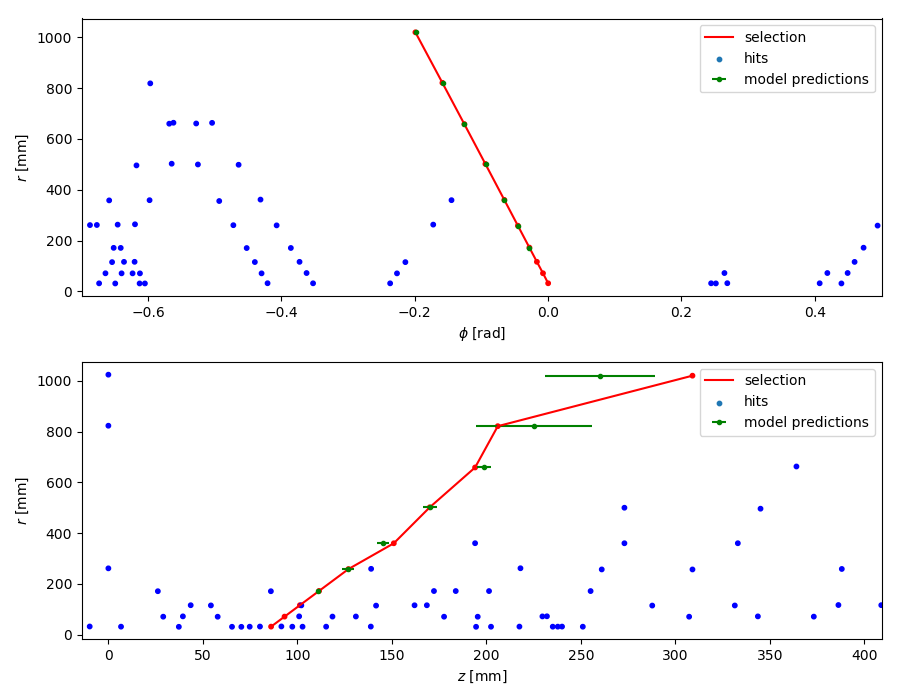

<IPython.core.display.Javascript object>


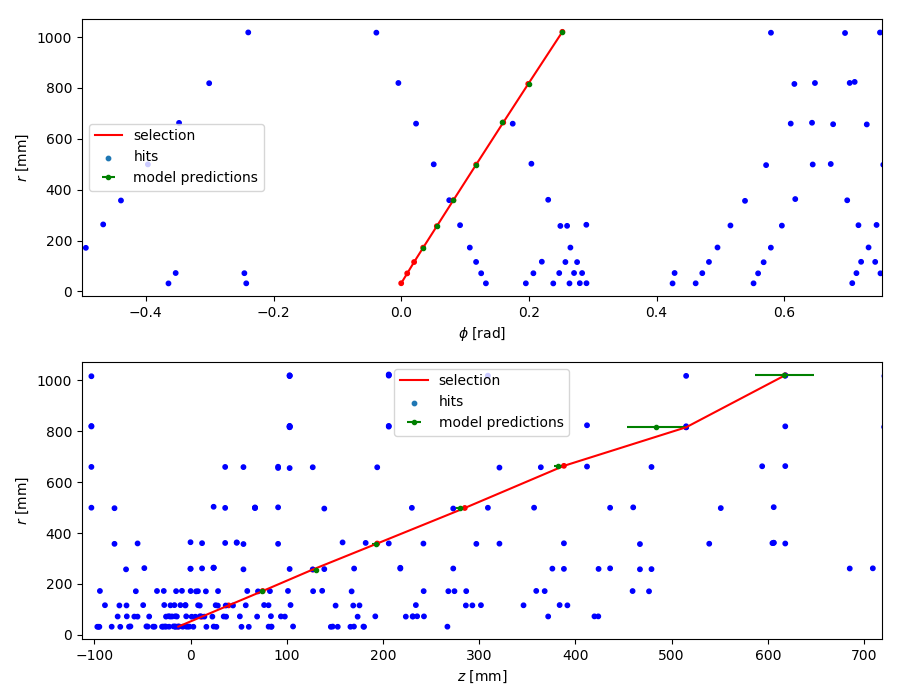

<IPython.core.display.Javascript object>


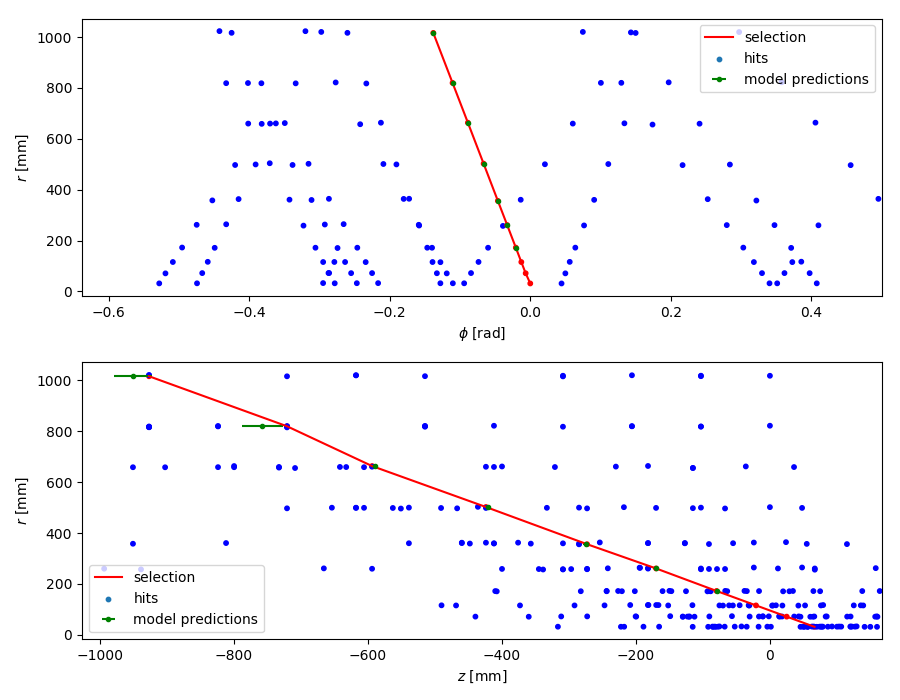

In [31]:
# Loop over samples to draw
for isample in draw_samples:
    sample_key = sample_keys[isample]

    # Get the hits for this sample
    sample_hits = event_groups.get_group(sample_key[0])
    sample_labels = sample_hits.barcode == sample_key[1]
    sel_idx = indices[isample]
    
    # Center the hits around the first seed hit for display
    phi0 = sample_hits.phi.loc[indices[isample, 0]]
    sample_phi = translate_phi(sample_hits.phi, phi0)
    
    # Get the hits selected by our model
    sel_r = sample_hits.r.loc[sel_idx]
    sel_phi = sample_phi.loc[sel_idx]
    sel_z = sample_hits.z.loc[sel_idx]
    
    # Get the model predictions
    pred_r = sel_r[seed_size:]
    pred_phi = pred_means[isample, :, 0]
    pred_z = pred_means[isample, :, 1]
    pred_phi_err = np.sqrt(pred_covs[isample, :, 0, 0])
    pred_z_err = np.sqrt(pred_covs[isample, :, 1, 1])

    plt.figure(figsize=(9, 7))

    # Draw r-phi
    plt.subplot(211)
    plt.scatter(sample_phi, sample_hits.r, c=sample_labels, s=10, cmap='bwr', label='hits')
    plt.plot(sel_phi, sel_r, 'r-', label='selection')
    plt.errorbar(pred_phi, pred_r, xerr=pred_phi_err, fmt='g.', label='model predictions')
    plt.xlim((sel_phi.min() - 0.5, sel_phi.max() + 0.5))
    plt.xlabel('$\phi$ [rad]')
    plt.ylabel('$r$ [mm]')
    plt.legend(loc=0)

    # Draw r-z
    plt.subplot(212)
    plt.scatter(sample_hits.z, sample_hits.r, c=sample_labels, s=10, cmap='bwr', label='hits')
    plt.plot(sel_z, sel_r, 'r-', label='selection')
    plt.errorbar(pred_z, pred_r, xerr=pred_z_err, fmt='g.', label='model predictions')
    plt.xlim((sel_z.min() - 100, sel_z.max() + 100))
    plt.xlabel('$z$ [mm]')
    plt.ylabel('$r$ [mm]')
    plt.legend(loc=0)

    plt.tight_layout()

In [32]:
# Worst samples
sorted_samples = labels.sum(axis=1).argsort()

In [33]:
sorted_samples[:3]

array([1662, 5870, 1652])

In [34]:
labels[sorted_samples[1]]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.], dtype=float32)

<IPython.core.display.Javascript object>


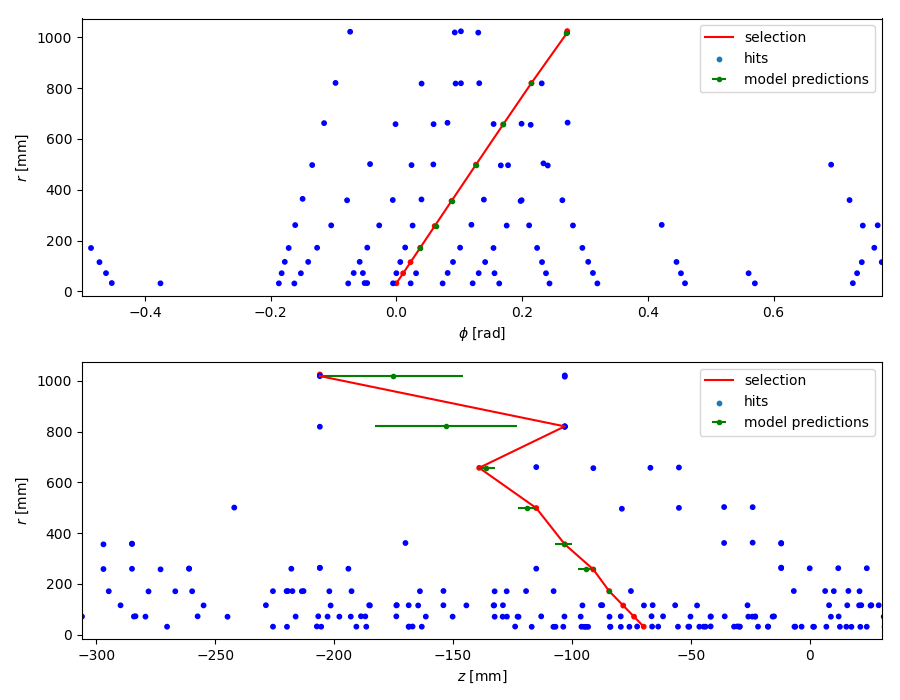

<IPython.core.display.Javascript object>


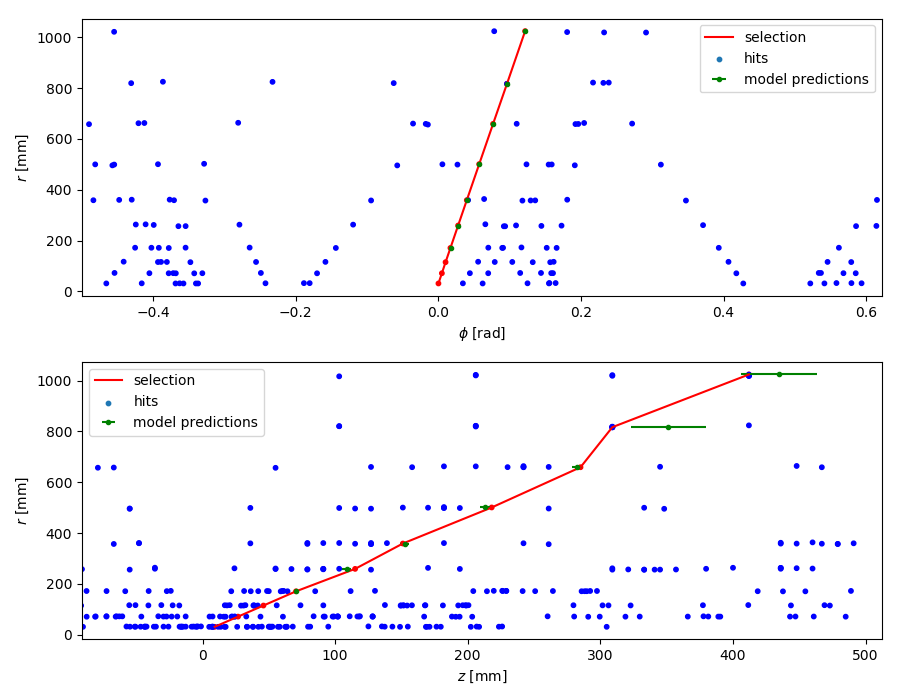

In [35]:
n_draw = 2

for isample in sorted_samples[:n_draw]:
    sample_key = sample_keys[isample]

    # Get the hits for this sample
    sample_hits = event_groups.get_group(sample_key[0])
    sample_labels = sample_hits.barcode == sample_key[1]
    sel_idx = indices[isample]
    
    # Center the hits around the first seed hit for display
    phi0 = sample_hits.phi.loc[indices[isample, 0]]
    sample_phi = translate_phi(sample_hits.phi, phi0)
    
    # Get the hits selected by our model
    sel_r = sample_hits.r.loc[sel_idx]
    sel_phi = sample_phi.loc[sel_idx]
    sel_z = sample_hits.z.loc[sel_idx]
    
    # Get the model predictions
    pred_r = sel_r[seed_size:]
    pred_phi = pred_means[isample, :, 0]
    pred_z = pred_means[isample, :, 1]
    pred_phi_err = np.sqrt(pred_covs[isample, :, 0, 0])
    pred_z_err = np.sqrt(pred_covs[isample, :, 1, 1])

    plt.figure(figsize=(9, 7))

    # Draw r-phi
    plt.subplot(211)
    plt.scatter(sample_phi, sample_hits.r, c=sample_labels, s=10, cmap='bwr', label='hits')
    plt.plot(sel_phi, sel_r, 'r-', label='selection')
    plt.errorbar(pred_phi, pred_r, xerr=pred_phi_err, fmt='g.', label='model predictions')
    plt.xlim((sel_phi.min() - 0.5, sel_phi.max() + 0.5))
    plt.xlabel('$\phi$ [rad]')
    plt.ylabel('$r$ [mm]')
    plt.legend(loc=0)

    # Draw r-z
    plt.subplot(212)
    plt.scatter(sample_hits.z, sample_hits.r, c=sample_labels, s=10, cmap='bwr', label='hits')
    plt.plot(sel_z, sel_r, 'r-', label='selection')
    plt.errorbar(pred_z, pred_r, xerr=pred_z_err, fmt='g.', label='model predictions')
    plt.xlim((sel_z.min() - 100, sel_z.max() + 100))
    plt.xlabel('$z$ [mm]')
    plt.ylabel('$r$ [mm]')
    plt.legend(loc=0)

    plt.tight_layout()

### Draw the 2D predictions on each layer

<IPython.core.display.Javascript object>


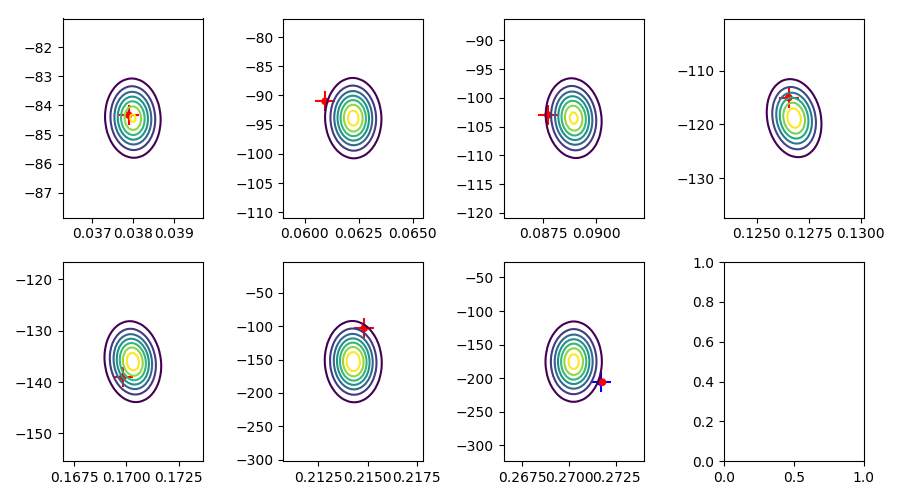

<IPython.core.display.Javascript object>


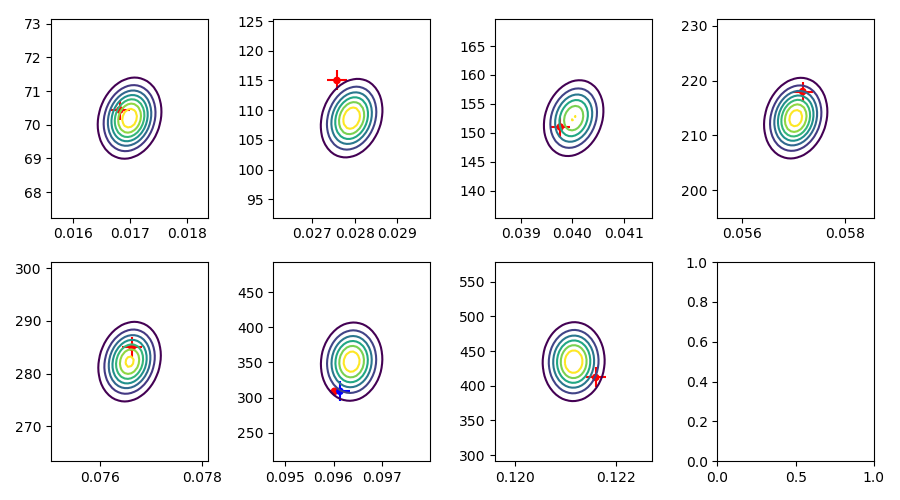

In [36]:
n_draw = 2

for isample in sorted_samples[:n_draw]:
    sample_key = sample_keys[isample]

    # Get the hits for this sample
    sample_hits = event_groups.get_group(sample_key[0])
    sample_labels = sample_hits.barcode == sample_key[1]
    # Center the hits around the first seed hit for display
    phi0 = sample_hits.phi.loc[indices[isample, 0]]
    sample_hits = sample_hits.assign(phi=translate_phi(sample_hits.phi, phi0))

    fig, axs = plt.subplots(2, 4, figsize=(9,5))
    axs = axs.flatten()

    # Loop over layers
    for ilayer in range(seed_size, n_det_layers):
        pred_layer = ilayer - seed_size
        ax = axs[pred_layer]

        # Get the hit selected by our model
        sel_idx = indices[isample, ilayer]
        sel_hit = sample_hits.loc[sel_idx]

        # Get the model predictions for this layer
        pred_phi = pred_means[isample, pred_layer, 0]
        pred_z = pred_means[isample, pred_layer, 1]
        pred_phi_err = np.sqrt(pred_covs[isample, pred_layer, 0, 0])
        pred_z_err = np.sqrt(pred_covs[isample, pred_layer, 1, 1])

        # Construct the gaussian distribution.
        # Have to use the scaled coordinates to avoid rounding errors.
        gaus = multivariate_normal(pred_means[isample, pred_layer] / coord_scale[:2],
                                   pred_covs[isample, pred_layer] / cov_scale)

        # Compute values of the gaussian on a 2-sigma wide grid
        grid_phi, grid_z = np.mgrid[pred_phi - 5*pred_phi_err : pred_phi + 5*pred_phi_err : 50j,
                                    pred_z   - 5*pred_z_err   : pred_z   + 5*pred_z_err   : 50j]
        grid_pred = gaus.pdf(np.dstack([grid_phi / coord_scale[0], grid_z / coord_scale[1]]))

        # Draw the hits
        layer_hits = sample_hits[sample_hits.layer == ilayer]
        layer_labels = sample_labels.loc[layer_hits.index]

        ax.contour(grid_phi, grid_z, grid_pred)
        ax.scatter(sel_hit.phi, sel_hit.z, marker='+', c=layer_labels.loc[sel_idx],
                   s=200, cmap='bwr', vmin=0, label='selected hit')
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.scatter(layer_hits.phi, layer_hits.z, c=layer_labels, s=20, cmap='bwr', label='hits')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()

## Discussion

The gaussian hit predictor model seems to be effective for scoring hits in this simple track builder. Interestingly it is not as accurate as the regression hit predictor, but this model is probably more useful.

I should next try to implement a combinatorial search by multiplying together the scores of the track hits.